# 머신러닝 모델을 이용한 대한민국 코로나19 신규 확진자 예측

## 패키지 설치

In [79]:
!pip install prophet plotly

## 라이브러리 불러오기

In [104]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

## 데이터 불러오기

In [109]:
# 코로나 19 한국 발생 현황
url = 'https://raw.githubusercontent.com/jooeungen/coronaboard_kr/master/kr_daily.csv'
df = pd.read_csv(url, on_bad_lines='skip')
df.shape

(1323, 7)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1323 non-null   int64  
 1   confirmed  1323 non-null   int64  
 2   death      1323 non-null   int64  
 3   released   1323 non-null   int64  
 4   tested     1323 non-null   int64  
 5   negative   1323 non-null   int64  
 6   critical   1142 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 72.5 KB


In [111]:
df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')
df['date']

0      2020-01-21
1      2020-01-22
2      2020-01-23
3      2020-01-24
4      2020-01-25
          ...    
1318   2023-08-31
1319   2023-09-01
1320   2023-09-02
1321   2023-09-03
1322   2023-09-04
Name: date, Length: 1323, dtype: datetime64[ns]

In [112]:
# 원하는 기간 설정 (2020-01-21부터 2022-01-17까지)
start_date = '2020-01-21'
end_date = '2022-01-17'

In [113]:
# 기간에 맞는 데이터 필터링
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

In [114]:
df.head(5)

,date,confirmed,death,released,tested,negative,critical
0,2020-01-21,1,0,0,1,0,NaN
1,2020-01-22,1,0,0,1,0,NaN
2,2020-01-23,1,0,0,1,0,NaN
3,2020-01-24,2,0,0,2,0,NaN
4,2020-01-25,2,0,0,2,0,NaN


In [115]:
df.tail(5)

,date,confirmed,death,released,tested,negative,critical
723,2022-01-13,678807,6210,575763,16118172,14052403,701.0
724,2022-01-14,683341,6259,576918,16122706,14052403,659.0
725,2022-01-15,687753,6281,580664,16127118,14052403,626.0
726,2022-01-16,691936,6310,582667,16131301,14052403,612.0
727,2022-01-17,695788,6333,584537,16135153,14052403,579.0


In [116]:
df['confirmed']

0           1
1           1
2           1
3           2
4           2
        ...  
723    678807
724    683341
725    687753
726    691936
727    695788
Name: confirmed, Length: 728, dtype: int64

## 전처리

### 결측치 확인

In [117]:
df.isnull()

,date,confirmed,death,released,tested,negative,critical
0,False,False,False,False,False,False,True
1,False,False,False,False,False,False,True
2,False,False,False,False,False,False,True
3,False,False,False,False,False,False,True
4,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...
723,False,False,False,False,False,False,False
724,False,False,False,False,False,False,False
725,False,False,False,False,False,False,False
726,False,False,False,False,False,False,False


In [118]:
df.isnull().sum()

date           0
confirmed      0
death          0
released       0
tested         0
negative       0
critical     181
dtype: int64

### 데이터 변환

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 728 entries, 0 to 727
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       728 non-null    datetime64[ns]
 1   confirmed  728 non-null    int64         
 2   death      728 non-null    int64         
 3   released   728 non-null    int64         
 4   tested     728 non-null    int64         
 5   negative   728 non-null    int64         
 6   critical   547 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 45.5 KB


In [120]:
df=df.drop(['death', 'released', 'tested', 'negative', 'critical'], axis=1)
df.tail()

,date,confirmed
723,2022-01-13,678807
724,2022-01-14,683341
725,2022-01-15,687753
726,2022-01-16,691936
727,2022-01-17,695788


### 결측치 처리

In [121]:
# 결측치 전방 및 후방 채우기
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
df.isnull().sum()

date         0
confirmed    0
dtype: int64

## 시각화

### Plot

In [122]:
# 한국 코로나19 확진자 트렌드를 그래프로 만든다

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=df.confirmed,
        name='Confirmed in Korea'
    )
)

fig.show()

## 학습

### Facebook Prophet

In [123]:
# Facebook Prophet 예측 모델에 넣을 데이터프레임을 만들어준다
df_prophet = df.rename(columns={
    'date': 'ds',
    'confirmed': 'y'
})

df_prophet.tail()

,ds,y
723,2022-01-13,678807
724,2022-01-14,683341
725,2022-01-15,687753
726,2022-01-16,691936
727,2022-01-17,695788


In [124]:
# Prophet에서 감안할 계절성을 선택해서 모델을 만든다
# changepoints을 추가하여 flexible 향상 (https://facebook.github.io/prophet/docs/trend_changepoints.html)

m = Prophet(
    changepoint_prior_scale=0.5, # trend를 더 flexible하게 만든다
    changepoint_range=0.95,
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(df_prophet)

future = m.make_future_dataframe(periods=7)

future.tail(7)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6is0e05f/2i5kw39o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6is0e05f/jf0jb3bl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77515', 'data', 'file=/tmp/tmp6is0e05f/2i5kw39o.json', 'init=/tmp/tmp6is0e05f/jf0jb3bl.json', 'output', 'file=/tmp/tmp6is0e05f/prophet_modeljp1l3wsw/prophet_model-20240622052059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:20:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:20:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
728,2022-01-18
729,2022-01-19
730,2022-01-20
731,2022-01-21
732,2022-01-22
733,2022-01-23
734,2022-01-24


## 예측

In [125]:
forecast = m.predict(future)

# yhat : 예측값, yhat_lower : 오차를 고려한 예측 최소값, yhat_upper : 오차를 고려한 예측 최대값
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
728,2022-01-18,716343.595144,712473.272629,720284.525059
729,2022-01-19,721836.637769,718110.342545,725577.546927
730,2022-01-20,727308.356471,723495.232201,731234.862668
731,2022-01-21,732755.817039,729192.477970,736835.681206
732,2022-01-22,738198.753319,734420.879027,742338.468240
733,2022-01-23,743524.705596,739549.550303,747384.437486
734,2022-01-24,748717.357360,744739.637740,752750.644047


### Plot Prediction

In [126]:
fig = plot_plotly(m, forecast)
py.iplot(fig)

### Plot changepoints

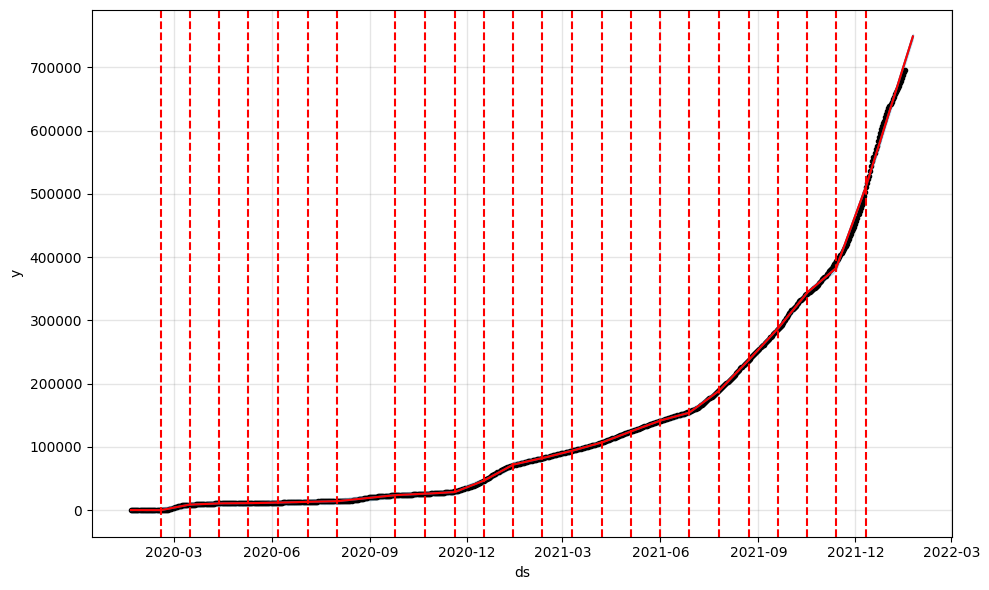

In [127]:
# changepoint를 그래프에 반영
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### 예측 성능 평가

In [128]:
# 실제값과 예측값 비교
# 예측을 시작하는 시점을 맞추기 위해 실제값의 마지막 7일이 아니라 전체 예측기간의 마지막 7일로 설정한다
y_true = df['confirmed'].values[-7:]  # 실제값
y_pred = forecast['yhat'].values[-7:]  # 예측값

# 실제값과 예측값을 확인하기 위해 출력
print("Actual values (last 7 days):", y_true)
print("Predicted values (last 7 days):", y_pred)

# MAE와 RMSE 계산
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

Actual values (last 7 days): [670269 674649 678807 683341 687753 691936 695788]
Predicted values (last 7 days): [716343.59514415 721836.63776902 727308.35647069 732755.81703892
 738198.75331907 743524.70559555 748717.35735997]
MAE: 49448.88895676586
RMSE: 49499.54204967924


### 교차 검증

In [129]:
# 교차 검증
df_cv = cross_validation(m, initial='365 days', period='180 days', horizon='90 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 2 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-10-19 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6is0e05f/xgjvg6ti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6is0e05f/u7e49c7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94582', 'data', 'file=/tmp/tmp6is0e05f/xgjvg6ti.json', 'init=/tmp/tmp6is0e05f/u7e49c7q.json', 'output', 'file=/tmp/tmp6is0e05f/prophet_modely934sjyt/prophet_model-20240622052101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:21:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:21:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6is0e05f/7c01nm2_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6is0e05f/iq7_1gq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,2.806285e+07,5297.438113,3971.922882,0.013028,0.010014,0.012925,0.000000
1,10 days,3.145480e+07,5608.457736,4230.266156,0.013785,0.010972,0.013670,0.000000
2,11 days,3.445641e+07,5869.958247,4437.570800,0.014315,0.011912,0.014190,0.000000
3,12 days,3.701905e+07,6084.328427,4603.435502,0.014703,0.012744,0.014568,0.055556
4,13 days,3.946956e+07,6282.480332,4759.719749,0.015098,0.013616,0.014956,0.111111


### 교차 검증 결과 시각화

In [130]:
# 교차 검증 RMSE를 시각화
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_p['horizon'],
        y=df_p['rmse'],
        mode='lines+markers',
        name='RMSE'
    )
)

fig.update_layout(
    title='Cross Validation RMSE over Horizon',
    xaxis_title='Horizon',
    yaxis_title='RMSE',
)

fig.show()